**Author**: Dhanavikram Sekar

# Analysis and Modeling

In [1]:
# Import necessary libraries
suppressPackageStartupMessages({library(tidyverse)
library(corrplot)
library(car)
library(leaps)
library(MASS)
library(lmtest)})

In [2]:
# Read data
data <- read.csv("jamboree_dataset.csv")

# Remove Serial.no (index)
data <- data[, !(names(data) %in% c("Serial.No."))]

In [3]:
head(data)

,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
6,330,115,5,4.5,3.0,9.34,1,0.90


## Exploratory Data Analysis

Boxplots and Histograms are used to visually analyze the distribution of each and every variable.

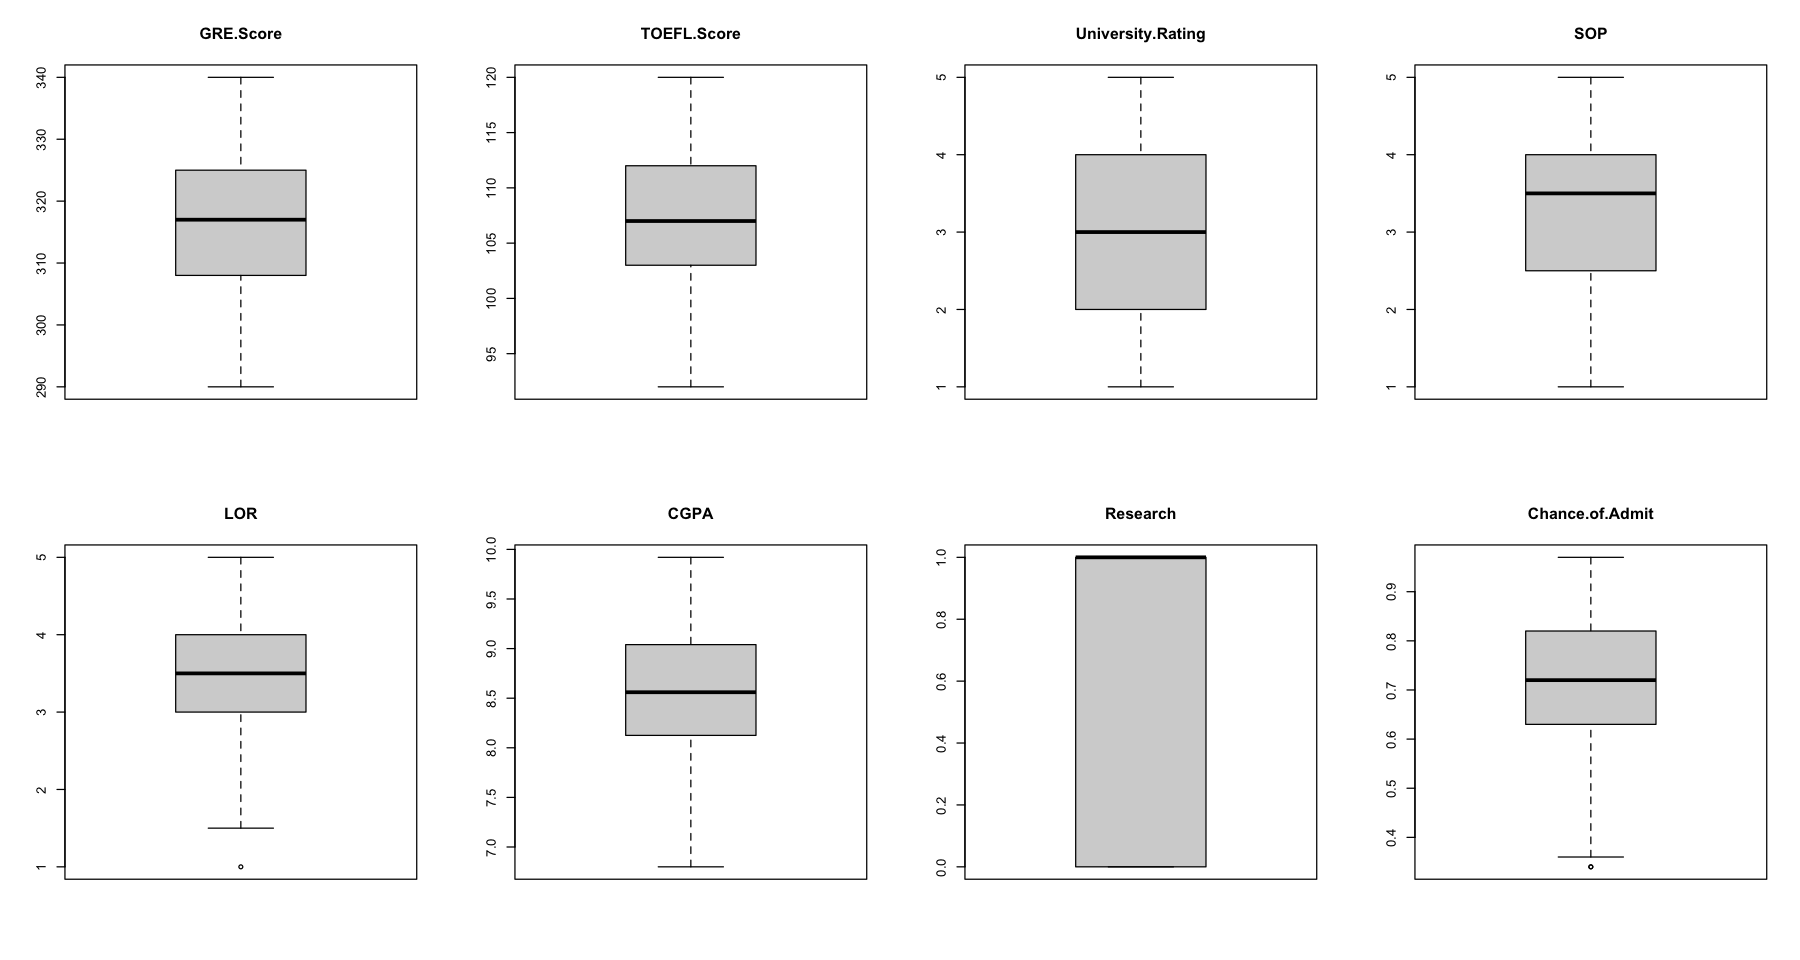

In [4]:
options(repr.plot.width = 15, repr.plot.height = 8)
par(mfrow = c(2, 4))

# Loop through each column and create a boxplot
for (col in names(data)) {
  boxplot(data[, col], main = col)
}

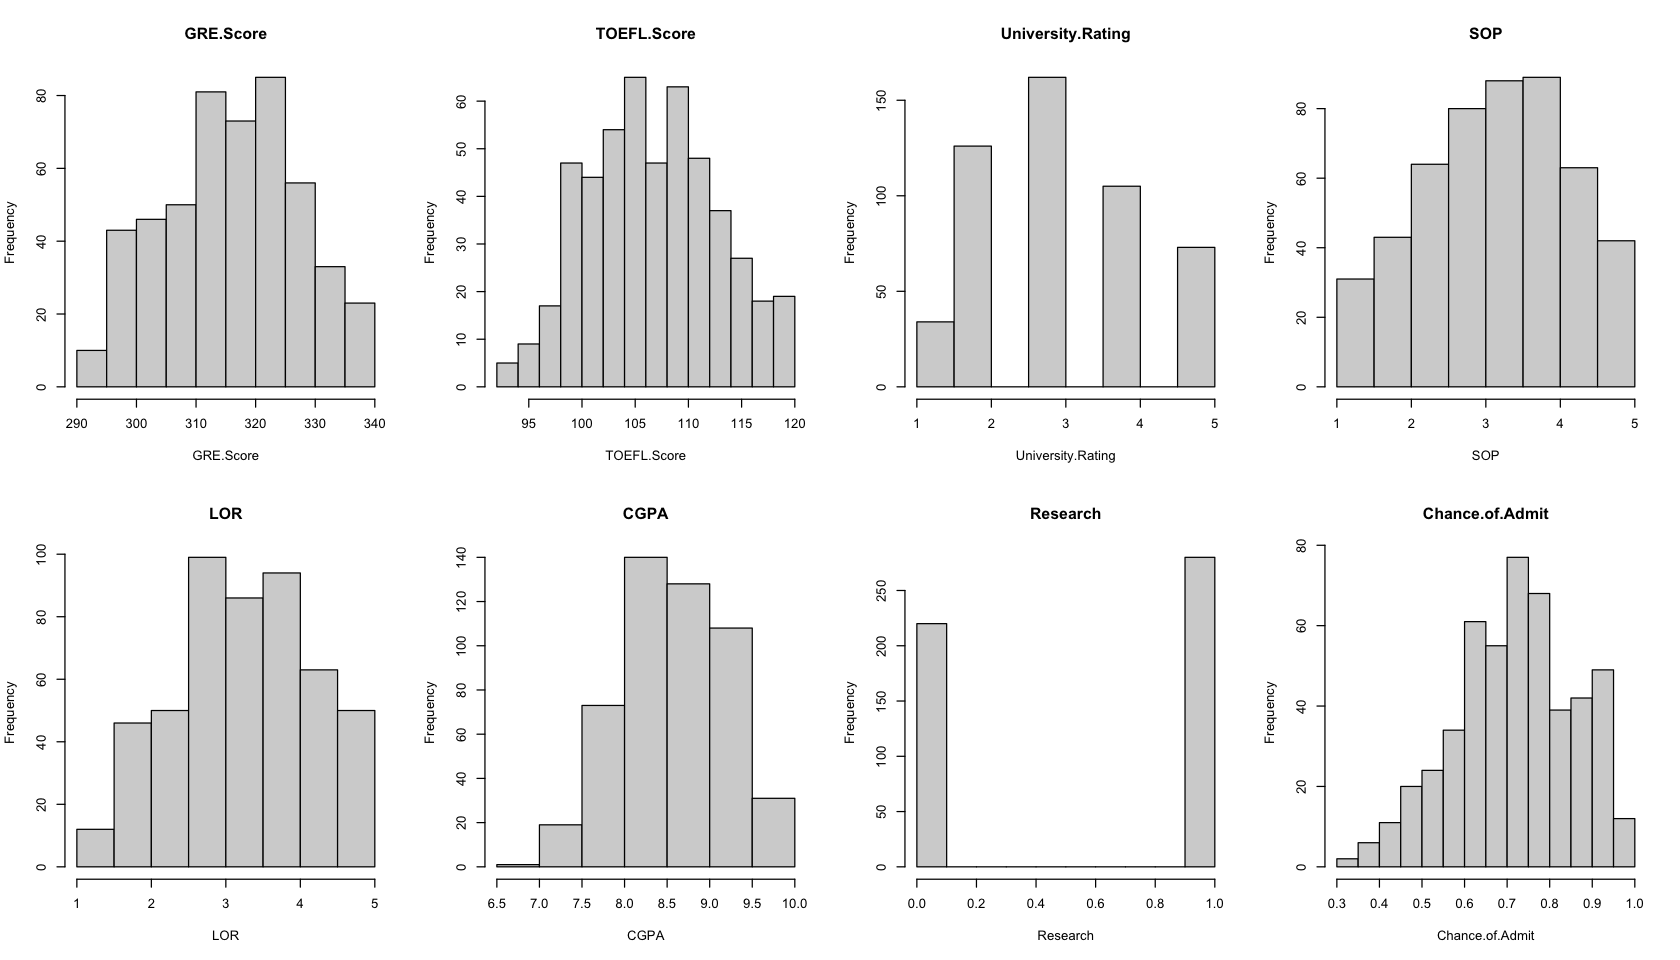

In [5]:
options(repr.plot.width = 14, repr.plot.height = 8)
par(mfrow = c(2, 4))

# Loop through each column and create a histogram
for (col in names(data)) {
  hist(data[, col], main = col, xlab = col)
}

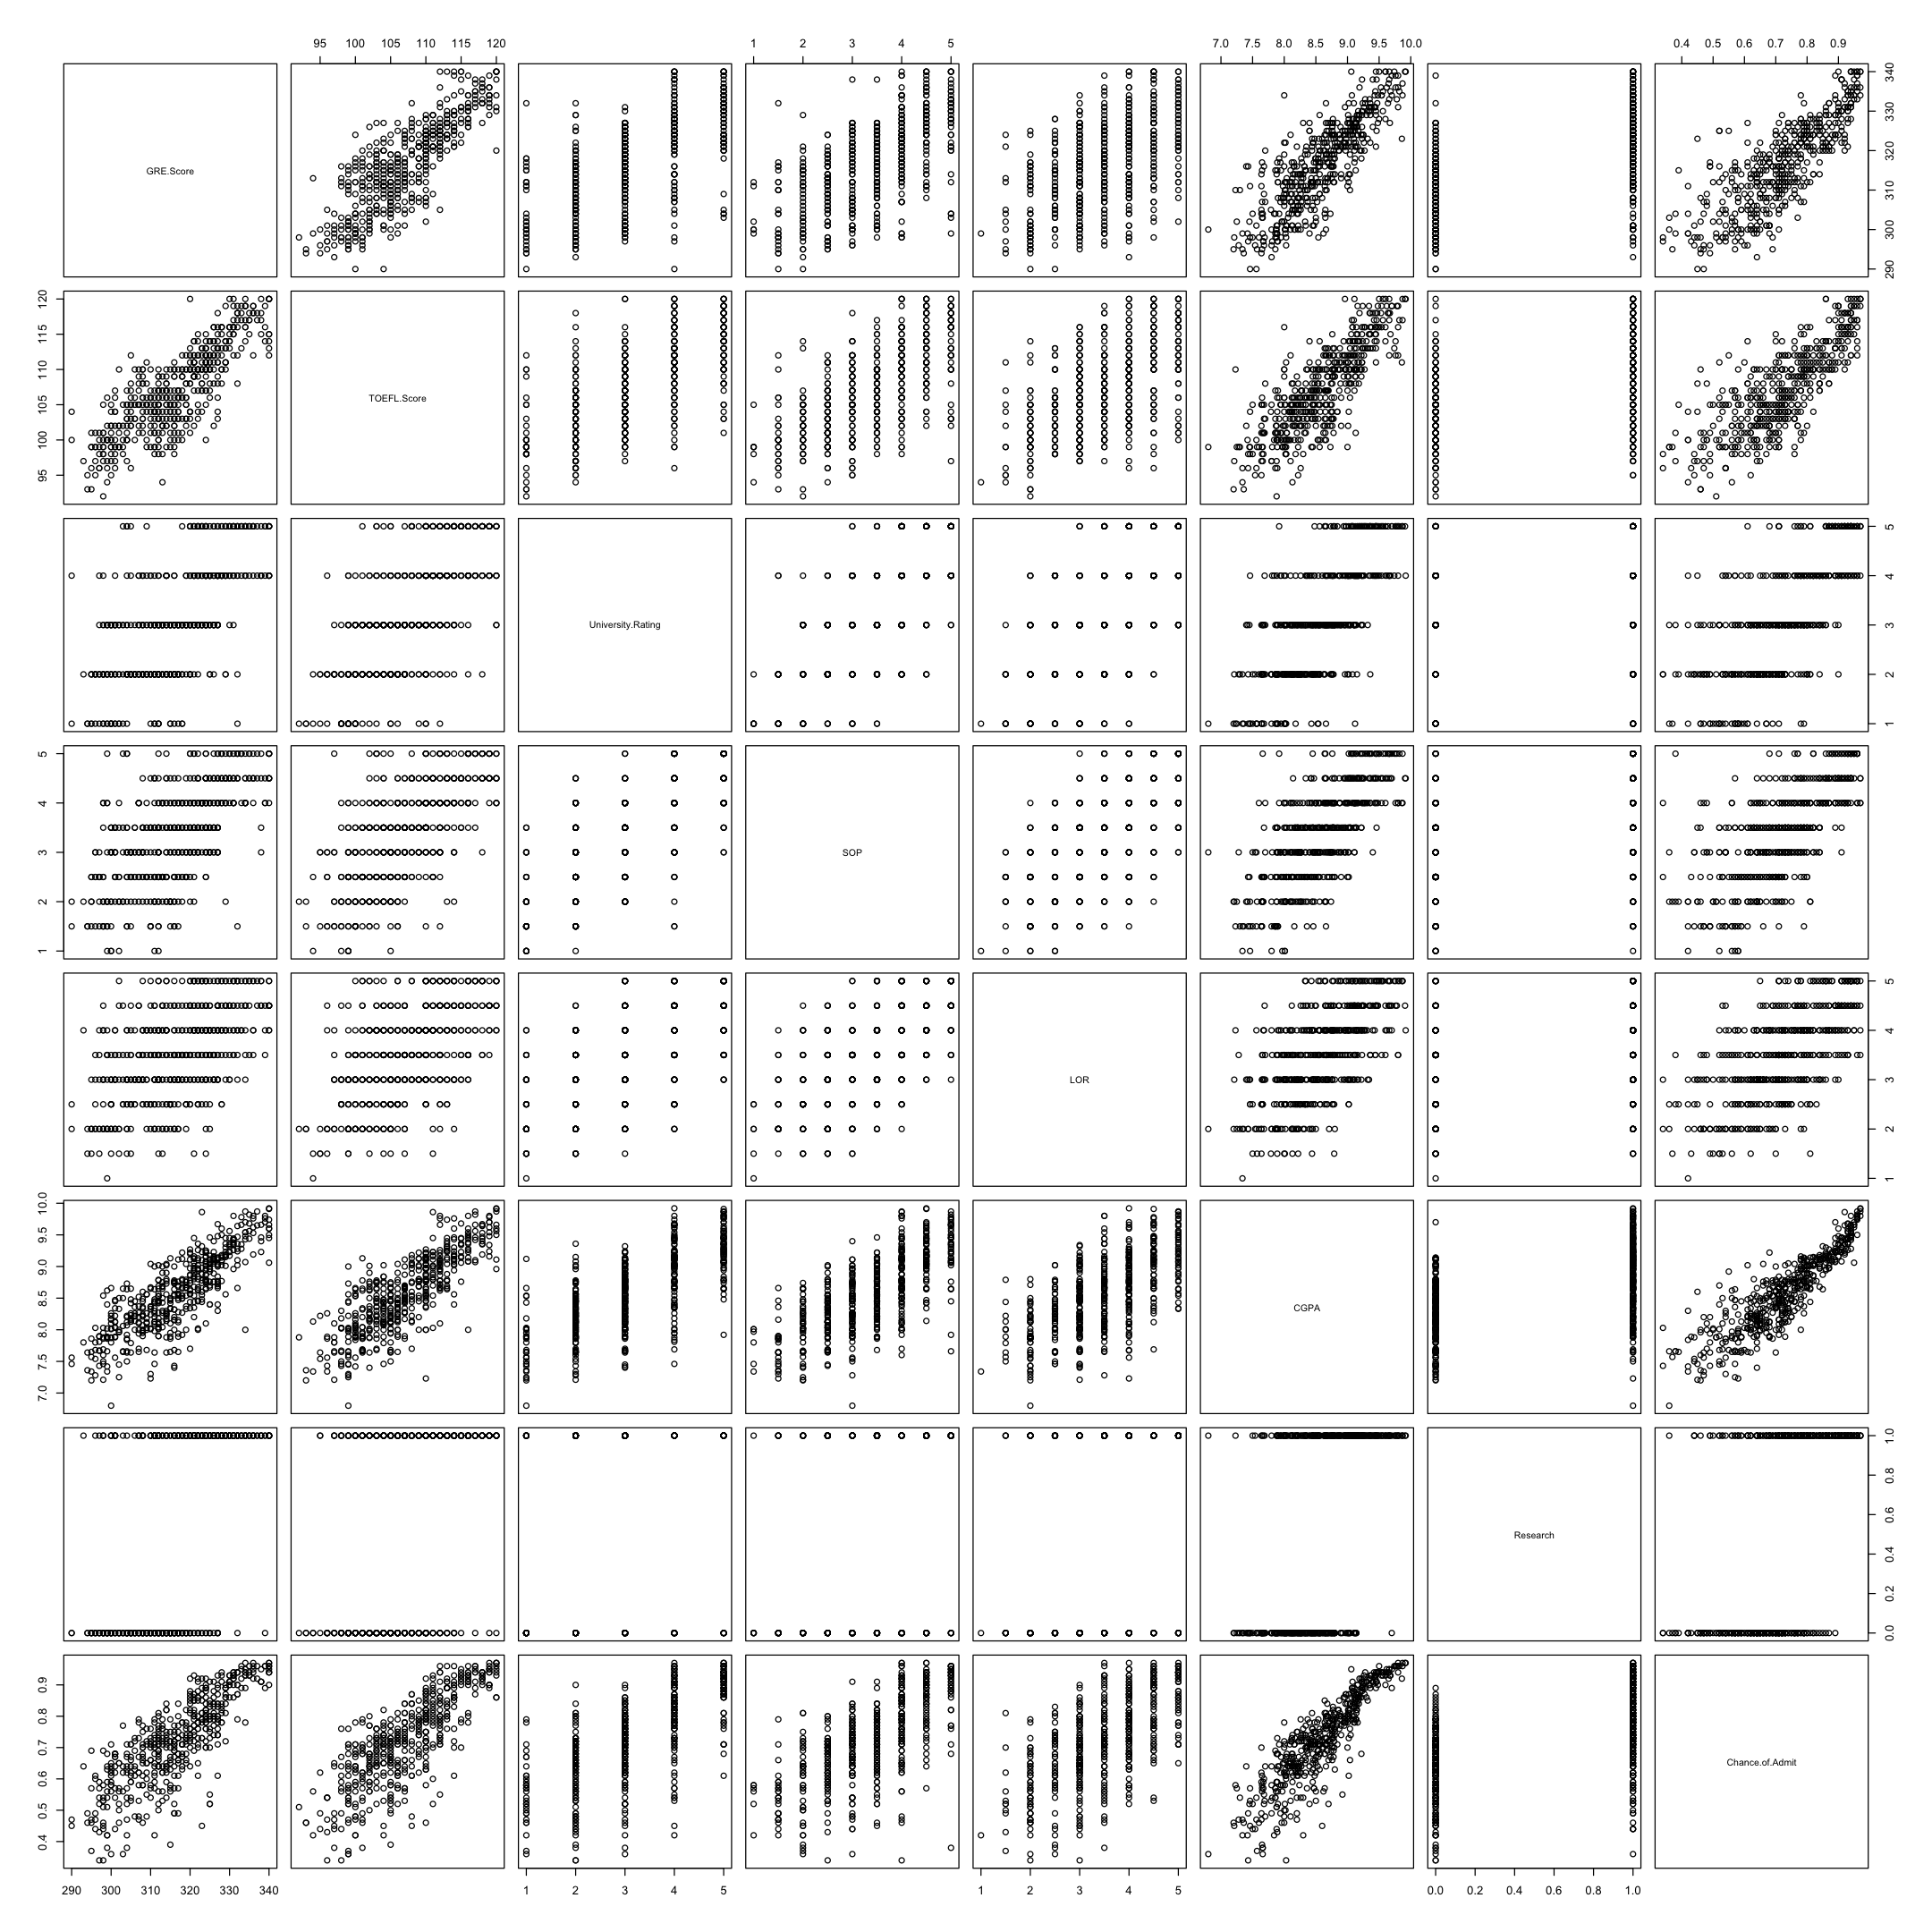

In [6]:
options(repr.plot.width = 18, repr.plot.height = 18)
# Scatter plot
pairs(data)

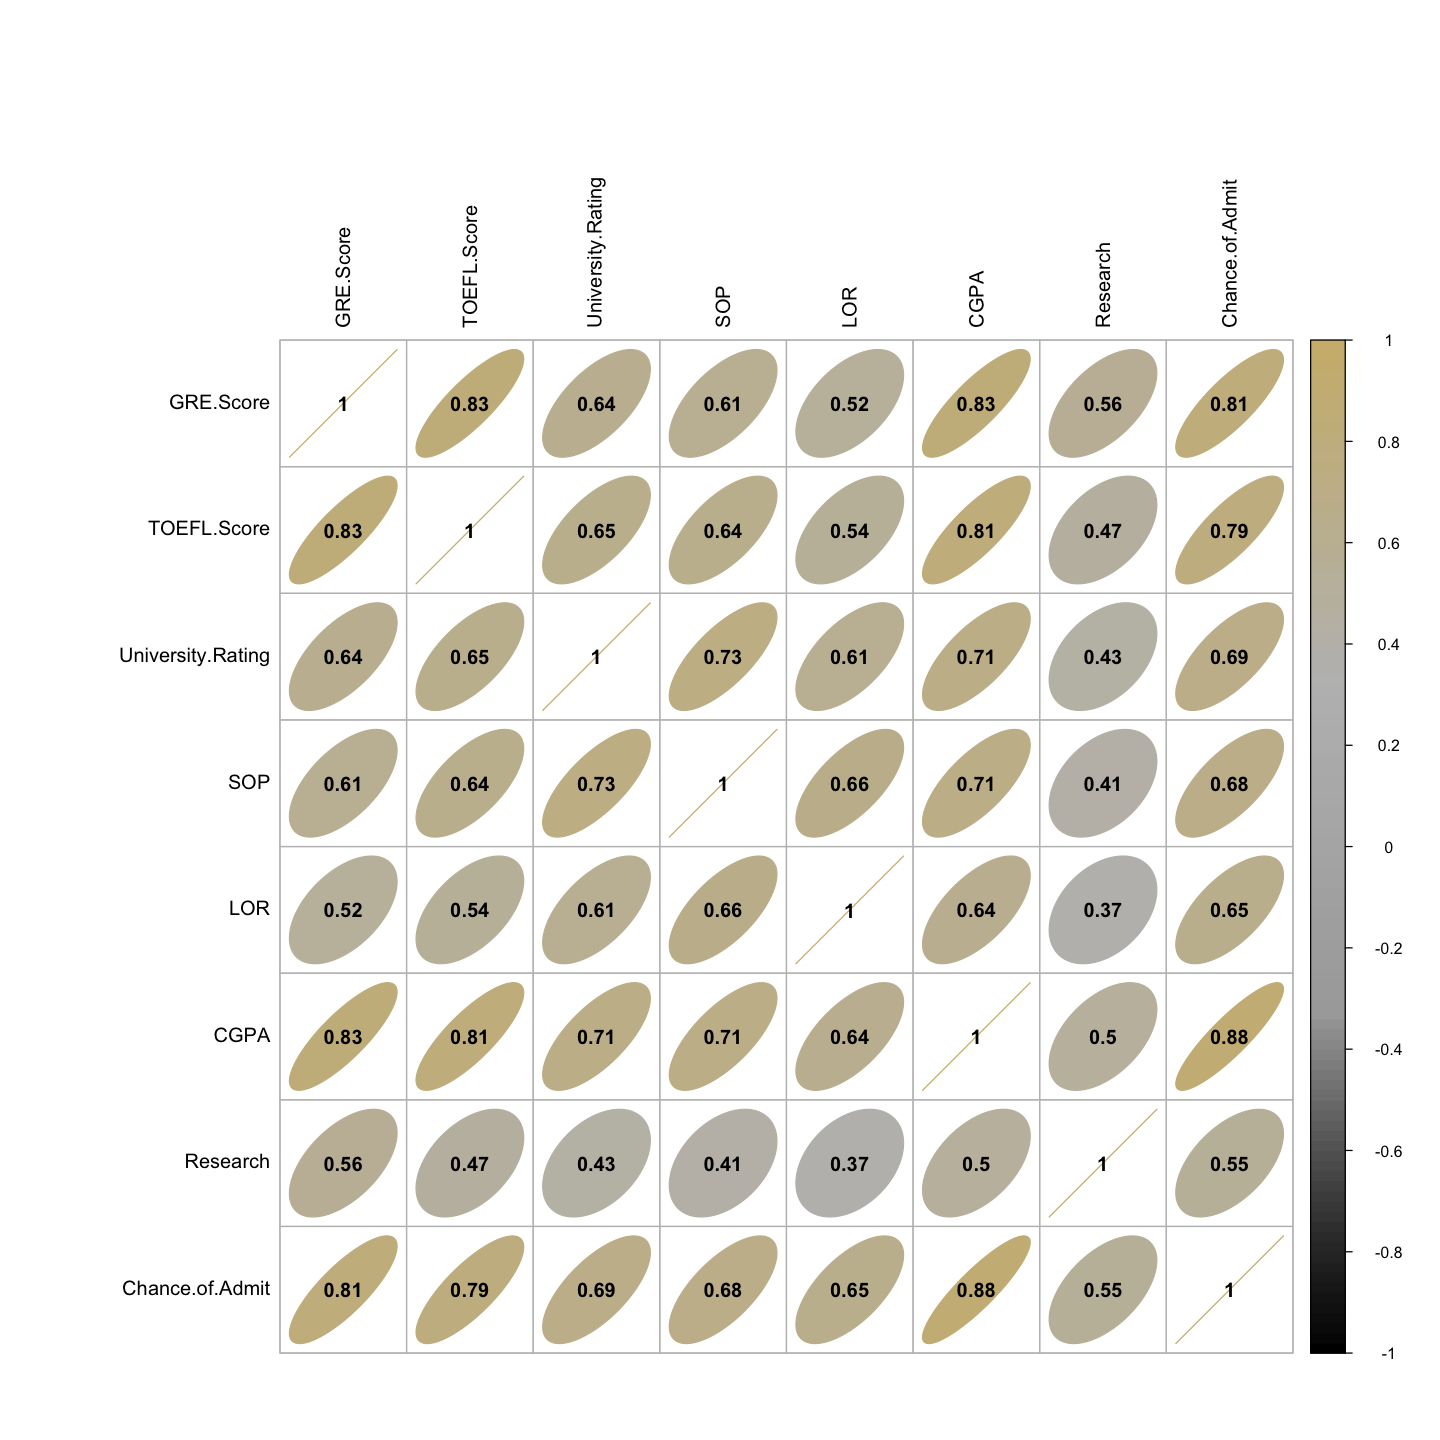

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12)
# Correlation plot
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(data), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

In [8]:
# Split the data into training and test set
set.seed(42)

# Number of data points if we consider 80% of the data
n <- floor(0.8 * nrow(data))

# Randomly sample the entire indices to get training indices of size n
index <- sample(seq_len(nrow(data)), size = n)

# Filter training and testing data based on the indices
train <- data[index, ]
test <- data[-index, ] 

cat("There are", dim(train)[1], "rows and", dim(train)[2], "columns in the training set.\n")
cat("There are", dim(test)[1], "rows and", dim(test)[2], "columns in the testing set.")

There are 400 rows and 8 columns in the training set.
There are 100 rows and 8 columns in the testing set.

80 percent of the data is chosen as training data. Linear model is fitted and it's assumptions are tested on the training data.

## Regression Analysis

In [9]:
# Full model - linear regression
full_model <- lm(Chance.of.Admit ~ ., train)
summary(full_model)


Call:
lm(formula = Chance.of.Admit ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.267688 -0.021796  0.009356  0.035503  0.153156 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.2756142  0.1203899 -10.596  < 2e-16 ***
GRE.Score          0.0018132  0.0005866   3.091  0.00214 ** 
TOEFL.Score        0.0027242  0.0010237   2.661  0.00811 ** 
University.Rating  0.0050926  0.0043646   1.167  0.24400    
SOP               -0.0005913  0.0054217  -0.109  0.91321    
LOR                0.0159520  0.0048114   3.315  0.00100 ** 
CGPA               0.1223668  0.0113596  10.772  < 2e-16 ***
Research           0.0249661  0.0076302   3.272  0.00116 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06284 on 392 degrees of freedom
Multiple R-squared:  0.7975,	Adjusted R-squared:  0.7939 
F-statistic: 220.5 on 7 and 392 DF,  p-value: < 2.2e-16


CGPA, Research, and LOR contribute the most to the model. The adjusted R-squared is also high. However, there are certain features whose p-value is higher than 0.05 indicating that these features might not be the best to represent the patterns in data. Feature selection can be used to solve this. However, the assumptions of linear regression are checked first by diagnosing the residuals of the fitted model before using this model for prediction.

## Diagnostics of Linear Model and Residuals

The most important assumptions of linear regression are as follows,

- Linearity 
- Independence of features (no multicollinearity)
- Normality of residuals
- Constant Variance (Homescedasticity)
- Independence of residuals

Some of these assumptions are visually assessed using different plots.

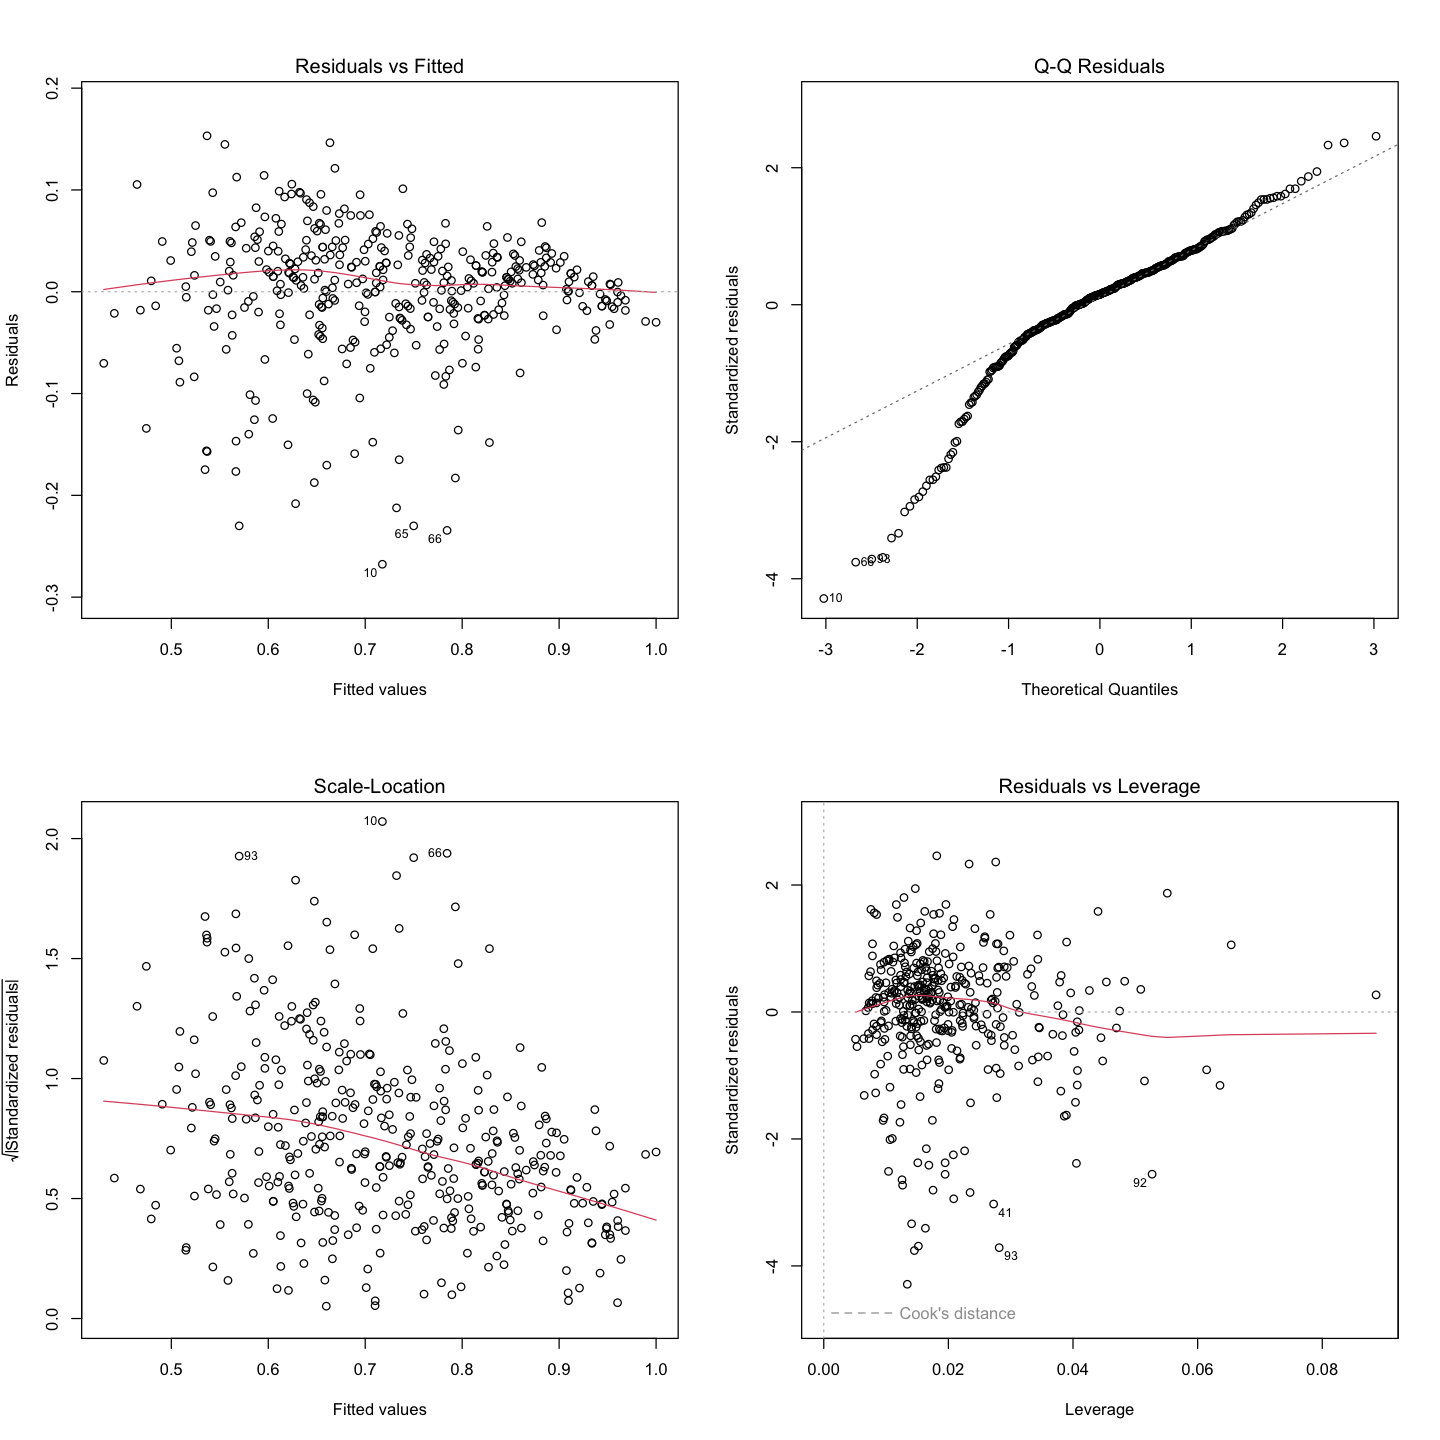

In [10]:
options(repr.plot.width = 12, repr.plot.height = 12)
par(mfrow = c(2, 2))
# Model diagnostics plot
plot(full_model)

**Linearity**: 

The presence of a linear line in the Fitted vs Residuals plot indicates the presence of a linear relationship between the features and the response.

**Homoscedasticity check**:

In [11]:
# Breusch-Pagan Test
bp_test <- bptest(full_model)
print(bp_test)


	studentized Breusch-Pagan test

data:  full_model
BP = 25.323, df = 7, p-value = 0.0006648



From the Fitted vs Residuals plot and the Fitted vs Standardized residuals plot, the variance of the residuals varying throughout the fitted values can be seen. Hence, the data does not follow the property of Homoscedasticity (Constant Variance).

To confirm this, the Breusch-Pagan test has been used. This test involves regressing the squared residuals from the original regression against the independent variables. The null hypothesis is that the variance of the errors is constant across observations. The small p-value(less than 0.05) indicates that the null hypothesis can be rejected. Hence the model's residuals do not have a constant variance.

**Normality**:

In [12]:
# Shapiro Wilk test
shapiro.test(residuals(full_model))


	Shapiro-Wilk normality test

data:  residuals(full_model)
W = 0.91282, p-value = 1.982e-14


From the QQ plot and the results of the Shapiro-Wilk test, it can be seen that the residuals are not normally distributed. In a Shapiro-Wilk test, the null hypothesis states that the data is normally distributed. The null hypothesis can be rejected since the p-value is very small (less than 0.05 significance level).

**Independence of Residuals**:

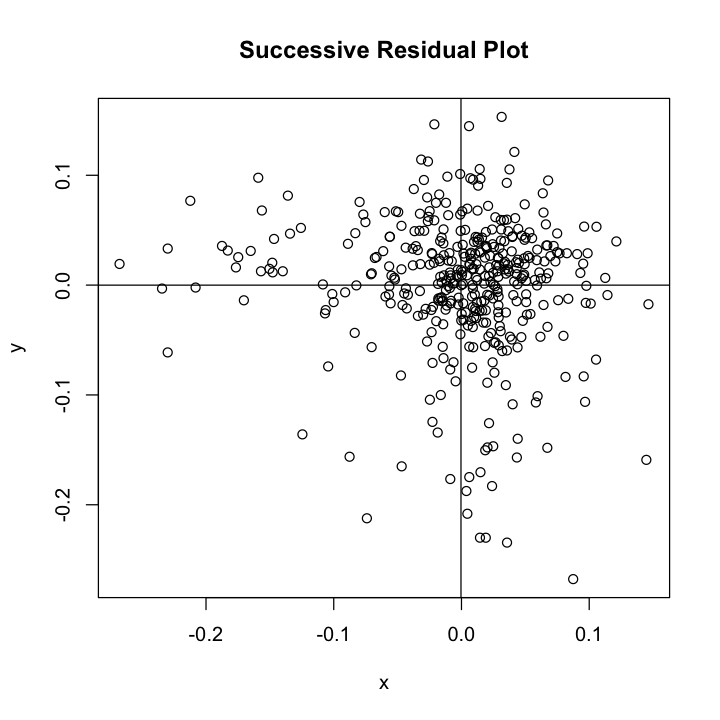

In [13]:
n <- dim(train)[1]
r <- residuals(full_model)
x <- head(r, n - 1)
y <- tail(r, n - 1)

options(repr.plot.width = 6, repr.plot.height = 6)
# Successive Residual Plot
plot(x, y, main = "Successive Residual Plot")
abline(v = mean(x), h = mean(y))

In [14]:
# Durbin Watson Test
durbinWatsonTest(full_model)

 lag Autocorrelation D-W Statistic p-value
   1      -0.0946561      2.174048   0.086
 Alternative hypothesis: rho != 0

In the Durbin-Watson test, the null hypothesis states that the errors are uncorrelated. Although the p-value is higher than the significance level (0.05), the p-value is very low. However, the autocorrelation value being closer to 0 indicates independence between successive residuals. Hence, the residuals are not correlated with each other.

**Multicollinearity**:

In [15]:
# Variance inflation factor
vif(full_model)

# Correlation matrix
cor(model.matrix(full_model)[, -1])

GRE.Score       TOEFL.Score University.Rating               SOP 
         4.382436          3.714195          2.489304          2.767500 
              LOR              CGPA          Research 
         1.943386          4.534959          1.441291

,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research
GRE.Score,1.0000000,0.8251838,0.6249601,0.6138392,0.5047341,0.8257859,0.5343993
TOEFL.Score,0.8251838,1.0000000,0.6227298,0.6219797,0.5076853,0.8003403,0.4540364
University.Rating,0.6249601,0.6227298,1.0000000,0.7183769,0.5897336,0.6850427,0.3986305
SOP,0.6138392,0.6219797,0.7183769,1.0000000,0.6521785,0.6984787,0.4157339
LOR,0.5047341,0.5076853,0.5897336,0.6521785,1.0000000,0.6065742,0.3779767
CGPA,0.8257859,0.8003403,0.6850427,0.6984787,0.6065742,1.0000000,0.4945948
Research,0.5343993,0.4540364,0.3986305,0.4157339,0.3779767,0.4945948,1.0000000


For this model, all the features have a VIF score of less than 5. Hence there is no multicollinearity. 

However, from the correlation matrix, it is discernible that the GRE score and TOEFL scores are highly correlated. Similarly, there is a high correlation between these features and the CGPA feature.

## Generalized Linear models

Since the probabilities of getting into an university are available, a generalized linear model(binomial/logistic model) can be built. For this, a variable called `estimated_admit` has been derived from `Chance.of.Admit`. Using this feature as a target feature, a binomial model has been built. 

In [16]:
# Create a binary class column
data$estimated_admit <- ifelse(data$Chance.of.Admit > 0.5, 1, 0)
data$estimated_admit <- as.factor(data$estimated_admit)
head(data)

,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit,estimated_admit
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>
1,337,118,4,4.5,4.5,9.65,1,0.92,1
2,324,107,4,4.0,4.5,8.87,1,0.76,1
3,316,104,3,3.0,3.5,8.00,1,0.72,1
4,322,110,3,3.5,2.5,8.67,1,0.80,1
5,314,103,2,2.0,3.0,8.21,0,0.65,1
6,330,115,5,4.5,3.0,9.34,1,0.90,1


In [17]:
# Fit logistic regression model
log_model <- glm(estimated_admit ~ .-Chance.of.Admit, data = data, family = binomial)
summary(log_model)


Call:
glm(formula = estimated_admit ~ . - Chance.of.Admit, family = binomial, 
    data = data)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -49.55729    9.69358  -5.112 3.18e-07 ***
GRE.Score           0.03885    0.03417   1.137  0.25553    
TOEFL.Score         0.10425    0.07302   1.428  0.15341    
University.Rating  -0.16395    0.28240  -0.581  0.56153    
SOP                -0.48223    0.31173  -1.547  0.12188    
LOR                 0.89489    0.33491   2.672  0.00754 ** 
CGPA                3.53086    0.78864   4.477 7.56e-06 ***
Research           -0.04265    0.53451  -0.080  0.93640    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 273.86  on 499  degrees of freedom
Residual deviance: 147.53  on 492  degrees of freedom
AIC: 163.53

Number of Fisher Scoring iterations: 8


### Logistic Regression Diagnostics

Similar to linear regression, logistic regression has its own set of assumptions that need to be satisfied. They are:

1. Appropriate outcome types
2. Linearity of independent variables and log odds
3. No strongly influential outliers
4. Absence of multicollinearity
5. Independence of observations
6. Sufficiently large sample size

Unlike linear regression, logistic regression does not assume the normality of residuals and homoscedasticity, which makes it the perfect model for this problem.

In [18]:
# Checking assumptions 1 and 6.
print(table(data$estimated_admit))


  0   1 
 39 461 


From this, it can be seen that there is a sufficiently large sample size for both classes (class imbalance problem not addressed in this specific scenario).

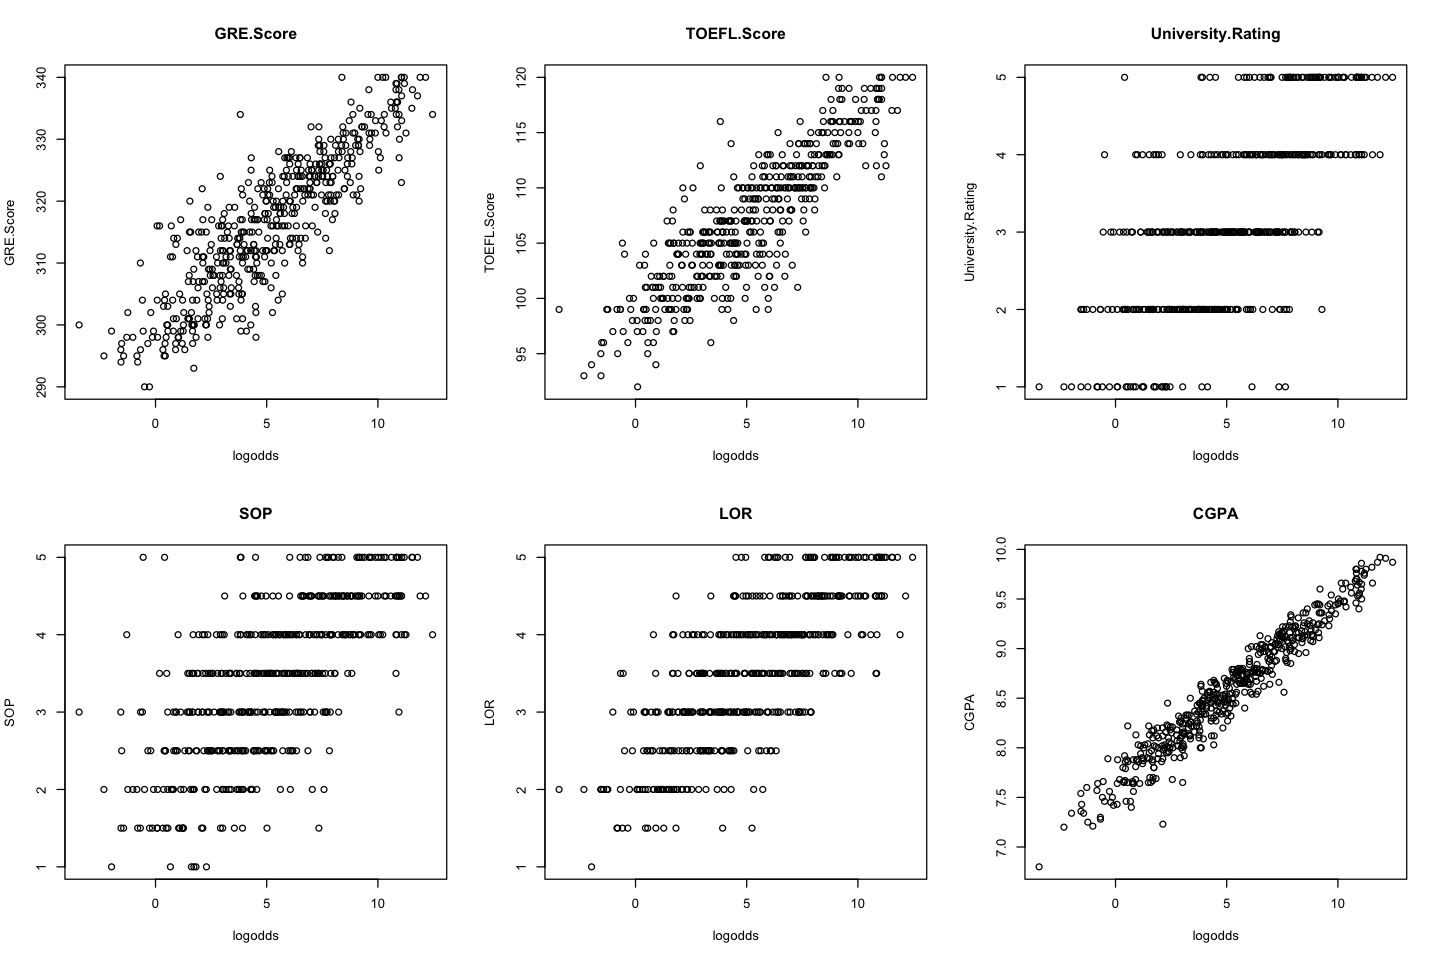

In [19]:
# Check assumption 2
logodds <- log_model$linear.predictors

options(repr.plot.width = 12, repr.plot.height = 8)
par(mfrow=c(2, 3))
for(col in names(data)[1:6]){
    plot(logodds, data[, col], main=col, ylab=col)
}


From the graph, it can be seen that there is a linear relationship between the log odds and the independent variables.

Assumptions 3, 4, and 5 have been checked in the previous Regression Model Diagnostics test.

### Train Test Split

In [20]:
# Split the data into training and test set
set.seed(42)

# Number of data points - we consider 80% of the data
n <- floor(0.8 * nrow(data))

# Randomly sample the entire indices to get training indices of size n
index <- sample(seq_len(nrow(data)), size = n)

# Filter training and testing data based on the indices
train <- data[index, ]
test <- data[-index, ] 

cat("There are", dim(train)[1], "rows and", dim(train)[2], "columns in the training set.\n")
cat("There are", dim(test)[1], "rows and", dim(test)[2], "columns in the testing set.")

There are 400 rows and 9 columns in the training set.
There are 100 rows and 9 columns in the testing set.

### Feature Selection - Backward Selection

Stepwise backward feature elimination has been used to select the best features.

In [21]:
# Full logistic regression model
full_log_model <- glm(estimated_admit ~ .-Chance.of.Admit, data = train, family = binomial)
summary(full_log_model)


Call:
glm(formula = estimated_admit ~ . - Chance.of.Admit, family = binomial, 
    data = train)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -45.78371   10.70600  -4.276  1.9e-05 ***
GRE.Score           0.05817    0.04049   1.437 0.150735    
TOEFL.Score         0.03127    0.08006   0.391 0.696134    
University.Rating   0.03049    0.31794   0.096 0.923613    
SOP                -0.60566    0.36387  -1.664 0.096018 .  
LOR                 0.78485    0.39171   2.004 0.045107 *  
CGPA                3.26955    0.86395   3.784 0.000154 ***
Research            0.19381    0.59241   0.327 0.743550    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 197.70  on 399  degrees of freedom
Residual deviance: 119.98  on 392  degrees of freedom
AIC: 135.98

Number of Fisher Scoring iterations: 8


In [22]:
# Reduced model
reduced_model <- full_log_model %>% stepAIC(direction = 'backward', trace = TRUE)
coef(reduced_model)

Start:  AIC=135.98
estimated_admit ~ (GRE.Score + TOEFL.Score + University.Rating + 
    SOP + LOR + CGPA + Research + Chance.of.Admit) - Chance.of.Admit

                    Df Deviance    AIC
- University.Rating  1   119.98 133.99
- Research           1   120.08 134.08
- TOEFL.Score        1   120.13 134.13
<none>                   119.98 135.98
- GRE.Score          1   122.15 136.15
- SOP                1   122.85 136.85
- LOR                1   124.26 138.26
- CGPA               1   136.63 150.63

Step:  AIC=133.98
estimated_admit ~ GRE.Score + TOEFL.Score + SOP + LOR + CGPA + 
    Research

              Df Deviance    AIC
- Research     1   120.09 132.09
- TOEFL.Score  1   120.16 132.16
<none>             119.98 133.99
- GRE.Score    1   122.16 134.16
- SOP          1   123.17 135.17
- LOR          1   124.34 136.34
- CGPA         1   136.67 148.67

Step:  AIC=132.09
estimated_admit ~ GRE.Score + TOEFL.Score + SOP + LOR + CGPA

              Df Deviance    AIC
- TOEFL.Score  1   

(Intercept)    GRE.Score          SOP          LOR         CGPA 
-46.43577909   0.06791602  -0.59416153   0.84032270   3.37074250

In [23]:
reduced_model$anova

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,392,119.9755,135.9755
- University.Rating,1,0.009215256,393,119.9847,133.9847
- Research,1,0.109609151,394,120.0943,132.0943
- TOEFL.Score,1,0.171589798,395,120.2659,130.2659


It can be seen that, throughout each step of the process, the AIC decreases. This indicates the reduction in model complexity while retaining the model's predictive power.

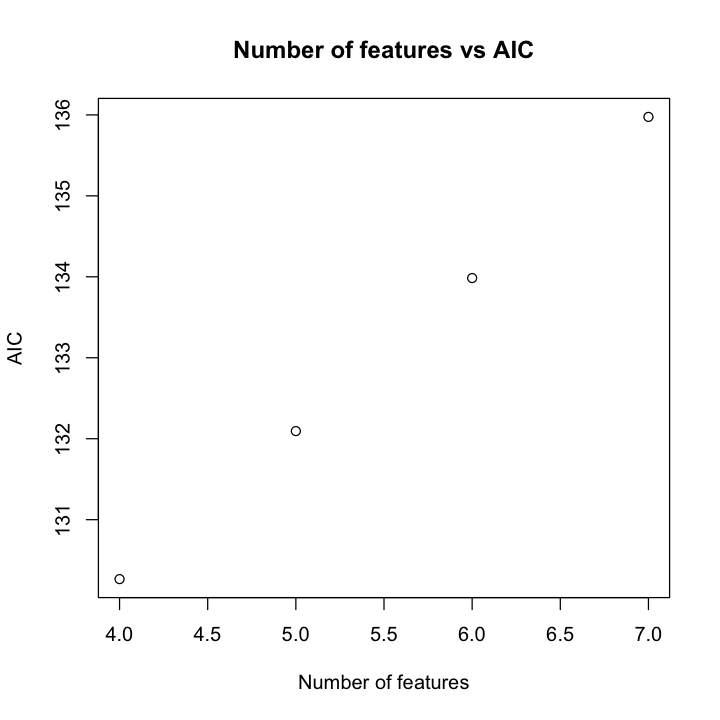

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6)
plot(seq(7, 4, -1), reduced_model$anova$AIC, xlab = "Number of features", ylab = "AIC", main = "Number of features vs AIC")

### Likelihood ratio test

Likelihood ratio test is method to assess the goodness of fit of a logistic model. In this test, 

**Null Hypothesis**: Reduced model is sufficient\
**Alternate Hypothesis**: Reduced model is not sufficient

In [25]:
# Likelihood ratio test
anova(full_log_model, reduced_model, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,392,119.9755,NA,NA,NA
2,395,120.2659,-3,-0.2904142,0.9618211


Since the p-value is greater than 0.05 significance level, we fail to reject the null hypothesis. Hence we can conclude that the reduced model is sufficient.

In [26]:
summary(reduced_model)


Call:
glm(formula = estimated_admit ~ GRE.Score + SOP + LOR + CGPA, 
    family = binomial, data = train)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -46.43578   10.45053  -4.443 8.86e-06 ***
GRE.Score     0.06792    0.03517   1.931   0.0535 .  
SOP          -0.59416    0.33337  -1.782   0.0747 .  
LOR           0.84032    0.37568   2.237   0.0253 *  
CGPA          3.37074    0.83967   4.014 5.96e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 197.70  on 399  degrees of freedom
Residual deviance: 120.27  on 395  degrees of freedom
AIC: 130.27

Number of Fisher Scoring iterations: 8


### Prediction on Test set

In [27]:
# Predict on the test set using full model
predictions <- predict(full_model, newdata = test, type = "response")

# Convert probabilities to binary predictions
binary_predictions <- ifelse(predictions > 0.5, 1, 0)

# Convert the target to numeric value for computing metrics
y_actual <- as.numeric(as.character(test$estimated_admit))

# Compute accuracy
accuracy <- mean(binary_predictions == y_actual)
cat("Accuracy:", accuracy, "\n")

# Compute precision
precision <- sum(binary_predictions & y_actual) / sum(binary_predictions)
cat("Precision:", precision, "\n")

# Compute recall
recall <- sum(binary_predictions & y_actual) / sum(y_actual)
cat("Recall:", recall, "\n")

Accuracy: 0.93 
Precision: 0.9263158 
Recall: 1 


In [28]:
# Predict on the test set using reduced model
predictions <- predict(reduced_model, newdata = test, type = "response")

# Convert the target to numeric value for computing metrics
y_actual <- as.numeric(as.character(test$estimated_admit))

# Compute accuracy
accuracy <- mean(binary_predictions == y_actual)
cat("Accuracy:", accuracy, "\n")

# Compute precision
precision <- sum(binary_predictions & y_actual) / sum(binary_predictions)
cat("Precision:", precision, "\n")

# Compute recall
recall <- sum(binary_predictions & y_actual) / sum(y_actual)
cat("Recall:", recall, "\n")

Accuracy: 0.93 
Precision: 0.9263158 
Recall: 1 


Interesting finding from this is that both the full model and the reduced model gives out the same accuracy, precision and recall.

## ANOVA (One way F-test)

Now it is known that this data can be used to estimate one's chance of getting admitted into a university. However, this data can also be used to answer other questions that a graduate student might have.

Do people with research experience have higher chances of admission as the logistic regression model does not consider it as a notable feature?  To find out the answer to this question, the ANOVA test has been used.

In [29]:
# Fit ANOVA model
train$Research <- as.factor(train$Research)
model <- aov(Chance.of.Admit ~ Research, data = train)

# Summarize the ANOVA results
summary(model)

             Df Sum Sq Mean Sq F value Pr(>F)    
Research      1  2.174  2.1742   158.2 <2e-16 ***
Residuals   398  5.469  0.0137                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Now that it is known that these two groups are statistically significant from each other, Tukey's HSD test can be used to find out how difference these groups are along with the confidence intervals.

In [30]:
# Tukey's HSD test
print(TukeyHSD(model))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Chance.of.Admit ~ Research, data = train)

$Research
         diff       lwr       upr p adj
1-0 0.1491407 0.1258311 0.1724502     0



This shows that there is a statistically significant difference between the groups. The difference in mean between the group with research experience(1) and group with no research experience(0) is positive(0.149) which suggests that the applicants with research experience have higher average probability of getting into an university of their choice compared to the applicants without any research experience.

## Hypothesis Testing (t-test)

Another analytical question that can be answered with this dataset is "Do students who have high TOEFL score write better Statement of Purpose (SOP) with higher ratings?"

To conduct a hypothesis test for this, we can categorize the applicants based on their TOEFL scores. 100 is chosen as the cutoff.

In [31]:
TOEFL_cat <- ifelse(data$TOEFL.Score >= 100, "High", "Low")
hyp_data <- data.frame(TOEFL_cat, data$SOP)
head(hyp_data)

,TOEFL_cat,data.SOP
,<chr>,<dbl>
1,High,4.5
2,High,4.0
3,High,3.0
4,High,3.5
5,High,2.0
6,High,4.5


**Null Hypothesis**: There is no significant difference in SOP ratings between students with high TOEFL scores and students with low TOEFL scores.\
**Alternate Hypothesis**: There is a significant difference in SOP ratings between students with high TOEFL scores and students with low TOEFL scores.

The assumptions of t-test are Normality (although t-test is robust to non-normality), Independence and Homogeneity of variance. They are checked before the test.

In [32]:
# Separate data into two groups based on TOEFL category
group_high <- hyp_data[hyp_data$TOEFL_cat== "High", "data.SOP"]
group_low <- hyp_data[hyp_data$TOEFL_cat == "Low", "data.SOP"]

# Perform Shapiro-Wilk test for normality
shapiro_test_high <- shapiro.test(group_high)
shapiro_test_low <- shapiro.test(group_low)

# View the results
shapiro_test_high
shapiro_test_low


	Shapiro-Wilk normality test

data:  group_high
W = 0.95443, p-value = 1.669e-10



	Shapiro-Wilk normality test

data:  group_low
W = 0.9457, p-value = 0.01622


We can see that one group is non-normal as its p-value is less than the significance level(0.05), while the other group is normal.

In [33]:
levene_test <- leveneTest(data.SOP ~ TOEFL_cat, data = hyp_data)
print(levene_test)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


Levene's Test for Homogeneity of Variance (center = median)
       Df F value Pr(>F)
group   1    0.58 0.4467
      498               


The p-value 0.4 suggests that the two groups have same variance.

Since it is known that the two groups are independent and have same variances, it can also be concluded it is safe to go with t-test (because t-test is robust to non-normality). 

In [34]:
# Perform t-test
t_test_result <- t.test(data.SOP ~ TOEFL_cat, data = hyp_data, var.equal = FALSE)

# View the t-test result
t_test_result


	Welch Two Sample t-test

data:  data.SOP by TOEFL_cat
t = 8.8813, df = 68.168, p-value = 5.419e-13
alternative hypothesis: true difference in means between group High and group Low is not equal to 0
95 percent confidence interval:
 0.880405 1.390646
sample estimates:
mean in group High  mean in group Low 
          3.496637           2.361111 


Kruskal-Wallis test is also conducted since its a non parametric test without any assumptions about the normality of the data to check on the results.

In [35]:
# Perform Kruskal-Wallis test
kruskal_test_result <- kruskal.test(data.SOP ~ TOEFL_cat, data = hyp_data)

# View the Kruskal-Wallis test result
kruskal_test_result


	Kruskal-Wallis rank sum test

data:  data.SOP by TOEFL_cat
Kruskal-Wallis chi-squared = 55.705, df = 1, p-value = 8.419e-14


The results of the t-test and Kruskal-Wallis test show that the groups are significantly different with a p-value less than 0.05 (significance level). The means of both groups also show that applicants who have TOEFL scores higher than 100 have a average SOP rating of approximately 3.5 while those with TOEFL scores lower than 100 have a average SOP rating of 2.36. 

With this, the question formulated above can be answered. i.e, Students who have higher TOEFL scores have higher SOP ratings.

## Inference

Based on the weights of the binomial model, it was evident that CGPA plays a major role in one's admission process, while GRE score does not play that much of a role in the admission process. Thus every applicant whose aim is to get admitted into a US university should focus more on getting a good CGPA that would allow them to become a competitive applicant in the present landscape.